In [22]:
# Data loading
import numpy as np
import pandas as pd 

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plot
%matplotlib inline

# Data preprocessing
from sklearn.preprocessing import RobustScaler

# Model training
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

# Model testing
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV

In [2]:
df = pd.read_csv('heart.csv')

## Exploratory Data Analysis & Data Cleaning

In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
df.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0
302,57,0,1,130,236,0,0,174,0,0.0,1,1,2,0


In [5]:
# Show statistics
stats = df.describe()
# Select the desired statistics
stats = stats.loc[['count','mean', 'std', 'min', '50%', 'max']]
nan_percentage = df.isnull().sum(axis = 0)*100 / len(df)
stats.loc['missing_values (%)'] = np.array(nan_percentage)
stats

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000
missing_values,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


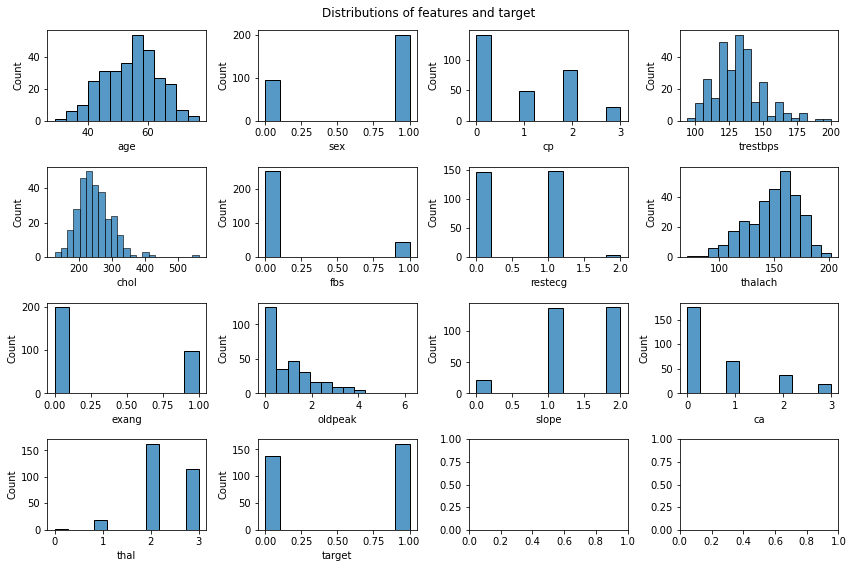

In [79]:
plot.plot_dists(df)

Some features such as olpeak and ca are heavily tailed. 

We notice that a value of 4 exists in the feature "ca". However, by definition, its value can only go upto 3. Therefore, we detect the number of such rows and remove them since they only occur 4 times in the dataset.

In [7]:
print("Number of duplicates in dataframe:", df.duplicated().sum(), "-- cleaning duplicates")
df = df[~df.duplicated(keep='first')]

print("Number of rows with ca value large than 3:", len(df[df.ca > 3]), "-- removing erronous rows (with ca > 3)")
df = df[df.ca <= 3]

print("Number of samples after cleaning:", len(df))

Number of duplicates in dataframe: 1 -- cleaning duplicates
Number of rows with ca value large than 3: 4 -- removing erronous rows (with ca > 3)
Number of samples after cleaning: 298


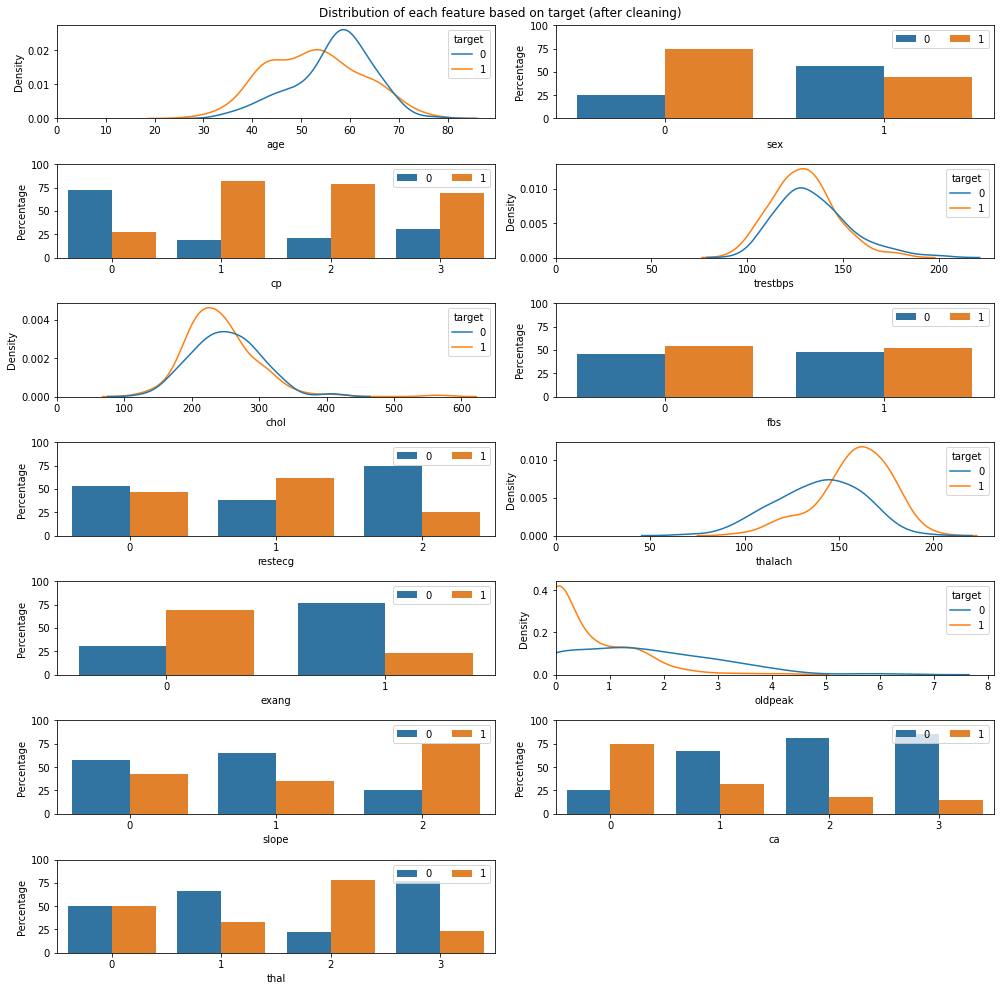

In [8]:
plot.plot_feat_target(df)

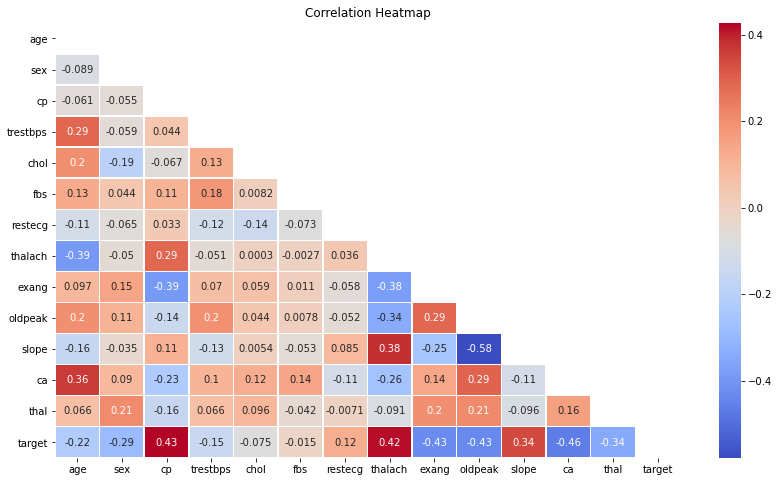

In [9]:
plot.plot_corr_heatmap(df)

Some features have a stronger correlation with the target variable than others. Therefore, we will conduct feature importance analysis and select the most important features to model.

## Model Preparation

In [10]:
X = df.drop('target',axis=1)
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 41) 

In [11]:
print("Distribution of target variable in train set:")
print(y_train.value_counts()/len(y_train))
print("\nDistribution of target variable in test set:")
print(y_test.value_counts()/len(y_test))

Distribution of target variable in train set:
1    0.567227
0    0.432773
Name: target, dtype: float64

Distribution of target variable in test set:
0    0.566667
1    0.433333
Name: target, dtype: float64


The target variable is distributed evenly in train and test sets.

In [12]:
# Scale features 
cols = X_train.columns
scaler = RobustScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=cols)
X_test = pd.DataFrame(scaler.transform(X_test), columns=cols)

### Feature Importance

In [61]:
# Select only important features for training
unimportant_features = [5, 6]
X_train_imp = X_train.drop(X_train.columns[unimportant_features], axis=1)   
X_test_imp = X_test.drop(X_test.columns[unimportant_features], axis=1)   

Feature: 0, Score: 0.08999
Feature: 1, Score: 0.04456
Feature: 2, Score: 0.14417
Feature: 3, Score: 0.06907
Feature: 4, Score: 0.07940
Feature: 5, Score: 0.00920
Feature: 6, Score: 0.01838
Feature: 7, Score: 0.12379
Feature: 8, Score: 0.05065
Feature: 9, Score: 0.10691
Feature: 10, Score: 0.03935
Feature: 11, Score: 0.12020
Feature: 12, Score: 0.10434


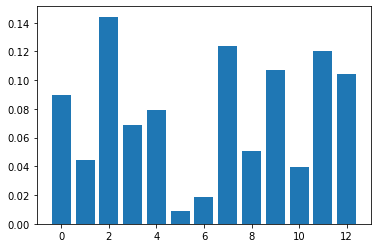

In [52]:
from matplotlib import pyplot
model = RandomForestClassifier()
# fit the model
model.fit(X_train, y_train)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [75]:
def maxN(elements, n):
    return sorted(elements, reverse=True)[:n]

In [78]:
maxN(importance, 12)

[0.14417066561228967,
 0.12379116645192362,
 0.12020048668124989,
 0.10691063749164761,
 0.10433631992108984,
 0.08998924433653804,
 0.07940310365084219,
 0.06906838555468268,
 0.05065421693805248,
 0.044557866576745146,
 0.039346933368285514,
 0.018375655579098496]

In [ ]:
# Sort age and sex importance and output for all models?

## ML models

In [95]:
def grid_search_results(model, param_grid, X_train):
    """
    """
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1', error_score=0)
    grid_result = grid_search.fit(X_train, y_train)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    
    print("Mean score: %f +/- %f" % (means.mean(), stds.mean()))
    
    return means.mean(), stds.mean(), importance

### 1. Logistic Regression

In [96]:
model = LogisticRegression()
param_grid = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['l2'],
    'C': [100, 10, 1.0, 0.1, 0.01]
}

# With all features
mean_lr, std_lr = grid_search_results(model, param_grid, X_train)

# With selected features
mean_lr_imp, std_lr_imp, lr_imp = grid_search_results(model, param_grid, X_train_imp)

Best: 0.869845 using {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Mean score: 0.862693 +/- 0.064769


ValueError: too many values to unpack (expected 2)

### 2. SVM

In [67]:
model = SVC()
param_grid = {
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'C': [50, 10, 1.0, 0.1, 0.01],
    'gamma': ['scale']
}

mean_svm, std_svm = grid_search_results(model, param_grid, X_train)

mean_svm_imp, std_svm_imp = grid_search_results(model, param_grid, X_train_imp)

Best: 0.860059 using {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
Mean score: 0.797347 +/- 0.058962
Best: 0.864683 using {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
Mean score: 0.800467 +/- 0.060599


### 3. K-NN

In [69]:
model = KNeighborsClassifier()
param_grid = {
    'n_neighbors': range(1, 55, 2),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

mean_knn, std_knn = grid_search_results(model, param_grid, X_train)

mean_knn_imp, std_knn_imp = grid_search_results(model, param_grid, X_train_imp)

Best: 0.866428 using {'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'uniform'}
Mean score: 0.847596 +/- 0.061940
Best: 0.872111 using {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'uniform'}
Mean score: 0.852727 +/- 0.060721


### 4. Ridge Classifier

In [70]:
model = RidgeClassifier()
param_grid = {
    'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

mean_ridge, std_ridge = grid_search_results(model, param_grid, X_train)

mean_ridge_imp, std_ridge_imp = grid_search_results(model, param_grid, X_train_imp)

Best: 0.865268 using {'alpha': 0.1}
Mean score: 0.864770 +/- 0.061734
Best: 0.871580 using {'alpha': 0.1}
Mean score: 0.870793 +/- 0.060121


### 5. Random Forest

In [71]:
model = RandomForestClassifier()
param_grid = {
    'n_estimators': [10, 100, 1000],
    'max_features': ['sqrt', 'log2']
}

mean_rf, std_rf = grid_search_results(model, param_grid, X_train)

mean_rf_imp, std_rf_imp = grid_search_results(model, param_grid, X_train_imp)

Best: 0.849806 using {'max_features': 'log2', 'n_estimators': 1000}
Mean score: 0.834306 +/- 0.066476
Best: 0.853696 using {'max_features': 'sqrt', 'n_estimators': 1000}
Mean score: 0.834208 +/- 0.068730


### 6. Bagging

In [72]:
model = BaggingClassifier()
param_grid = {
    'n_estimators': [10, 100, 250, 500, 1000]
}

mean_bag, std_bag = grid_search_results(model, param_grid, X_train)

mean_bag_imp, std_bag_imp = grid_search_results(model, param_grid, X_train_imp)

Best: 0.825052 using {'n_estimators': 500}
Mean score: 0.816981 +/- 0.066504
Best: 0.828233 using {'n_estimators': 1000}
Mean score: 0.825296 +/- 0.070502


### 7. Stochastic Gradient Boosting

In [ ]:
model = GradientBoostingClassifier()
param_grid = {
    'n_estimators': [10, 100, 500, 1000],
    'learning_rate': [0.001, 0.01, 0.1],
    'subsample': [0.5, 0.7, 1.0],
    'max_depth': [3, 7, 9]
}

mean_sgb, std_sgb = grid_search_results(model, param_grid, X_train)

mean_sgb_imp, std_sgb_imp = grid_search_results(model, param_grid, X_train_imp)

### 8. Multilayer Perceptron

In [ ]:
model = MLPClassifier()
param_grid = {
    'alpha': [0.1,0.01,0.02,0.005,0.0001,0.00001],
    'hidden_layer_sizes': [(10,10,10),
                         (100,100,100),
                         (100,100),
                         (3,5),
                         (5,3)],
    'solver': ['lbfgs','adam','sgd'],
    'activation': ['relu','logistic']
}

mean_mlp, std_mlp = grid_search_results(model, param_grid)

## Model Evaluation

In [124]:
# test all best tuned models on test sets
# graph all means and stds barplot with stds, take code from mlbd hw
# Write importance of age and sex

- feature selection yap: https://towardsdatascience.com/the-5-feature-selection-algorithms-every-data-scientist-need-to-know-3a6b566efd2 
- graph to show the performances of all models
- comment, refactor, make code totally your own, delete unnecessary imports
- write explanations & conclusion
- female male labellari dogru mu? 